In [54]:
import pandas as pd
import numpy as np

1) подготовка данных

In [55]:
train = pd.read_csv('../datasets/insurance_test.csv')
test = pd.read_csv('../datasets/insurance_train.csv')

In [56]:
train.head()

,age,sex,bmi,children,smoker,region,charges
0,61,male,38.380,0,no,northwest,12950.07120
1,59,female,34.800,2,no,southwest,36910.60803
2,31,male,30.875,0,no,northeast,3857.75925
3,24,female,33.345,0,no,northwest,2855.43755
4,31,male,28.500,5,no,northeast,6799.45800


In [57]:
test.head()

,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1000 non-null   int64  
 1   sex       1000 non-null   object 
 2   bmi       1000 non-null   float64
 3   children  1000 non-null   int64  
 4   smoker    1000 non-null   object 
 5   region    1000 non-null   object 
 6   charges   1000 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 54.8+ KB


In [59]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       338 non-null    int64  
 1   sex       338 non-null    object 
 2   bmi       338 non-null    float64
 3   children  338 non-null    int64  
 4   smoker    338 non-null    object 
 5   region    338 non-null    object 
 6   charges   338 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 18.6+ KB


In [60]:
print(train['children'].unique())
print(train['region'].unique())
print(train['sex'].unique())
print(train['smoker'].unique())


[0 2 5 3 1 4]
['northwest' 'southwest' 'northeast' 'southeast']
['male' 'female']
['no' 'yes']


In [61]:
num_features = ['age', 'bmi', 'charges']
cat_features = ['sex', 'smoker', 'region', 'children']

In [62]:
train_outliers = ((train[num_features] - train[num_features].mean()).abs() > 3 * train[num_features].std()).all(axis=1)
train_outliers.sum()

np.int64(0)

In [63]:
test_outliers = ((test[num_features] - test[num_features].mean()).abs() > 3 * test[num_features].std()).all(axis=1)
test_outliers.sum()

np.int64(0)

In [64]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le_sex = LabelEncoder()
le_smo = LabelEncoder()

In [65]:
train['sex'] = le_sex.fit_transform(train['sex'])
train['smoker'] = le_smo.fit_transform(train['smoker'])

test['sex'] = le_sex.transform(test['sex'])
test['smoker'] = le_smo.transform(test['smoker'])

In [66]:
train = pd.get_dummies(train, columns=['region'], prefix='region', drop_first=True)
test = pd.get_dummies(test, columns=['region'], prefix='region', drop_first=True)

In [67]:
train.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,61,1,38.380,0,0,12950.07120,True,False,False
1,59,0,34.800,2,0,36910.60803,False,False,True
2,31,1,30.875,0,0,3857.75925,False,False,False
3,24,0,33.345,0,0,2855.43755,True,False,False
4,31,1,28.500,5,0,6799.45800,False,False,False


In [68]:
train['charges'].describe()

count     1000.000000
mean     12992.437660
std      11864.228619
min       1135.940700
25%       4683.139575
50%       9237.375800
75%      15262.519162
max      62592.873090
Name: charges, dtype: float64

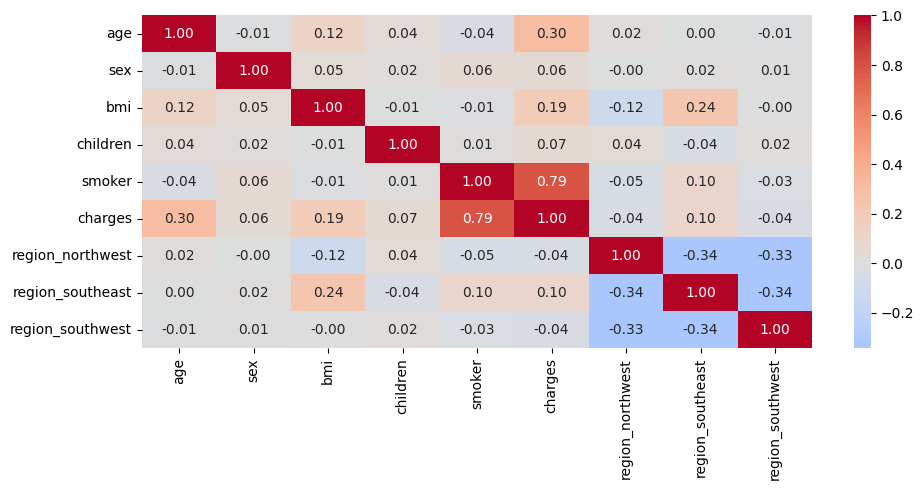

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.tight_layout()
plt.show()

2. многомерная линейная регрессия

In [70]:
X_train = train.drop(columns=['charges']).values
y_train = train['charges'].values
X_test = test.drop(columns=['charges']).values
y_test = test['charges'].values

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [72]:
def analytical_solution(X, y, l_r=0):
    X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
    
    if l_r > 0:
        reg = np.eye(X_with_bias.shape[1])
        reg[0, 0] = 0
        w = np.linalg.inv(X_with_bias.T @ X_with_bias + l_r * reg) @ X_with_bias.T @ y
    else:
        w = np.linalg.pinv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
    return w

In [73]:
from numpy.linalg import norm

class MyLinearRegression():

    def __init__(self, alpha=0, lr=0.5, max_iter=1000, fit_intercept=True, eps=1e-6):
        self.alpha = alpha
        self.lr = lr
        self.max_iter = int(max_iter)
        self.fit_intercept = fit_intercept
        self.eps = eps
        self.loss_history = []
    
    def _add_intercept(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def fit(self, X, y):
        self.coef_ = np.random.normal(loc=0.0, scale=0.01, size=X.shape[1]) 
        self.intercept_ = 0 

        samples_num = X.shape[0]

        for step in range(self.max_iter):
            y_pred = np.dot(X, self.coef_) + (self.intercept_ if self.fit_intercept else 0)
            errors = y_pred - y

            old_coef = self.coef_.copy()
            old_intercept = self.intercept_

            grad_coef = (2/samples_num ) * np.dot(X.T, errors) + 2 * self.alpha * self.coef_
            self.coef_ -= self.lr * grad_coef

            if self.fit_intercept:
                grad_inte = (2/samples_num ) * np.sum(errors)
                self.intercept_ -= self.lr * grad_inte

            if norm(old_coef - self.coef_) < self.eps and abs(old_intercept - self.intercept_)< self.eps:
                print(f"Converged at iteration {step}")
                break
        
            mse = np.mean(errors**2)
            self.loss_history.append(mse)

            if step % 10 == 0:
                print(f"Iteration {step}, MSE: {mse:.4f}")

        self.weights = np.append(self.intercept_, self.coef_) if self.fit_intercept else self.coef_.copy()

        return self
    
    def predict(self, X):
        if self.fit_intercept:
            X_with_intercept = self._add_intercept(X)
            return np.dot(X_with_intercept, self.weights)
        else:
            return np.dot(X, self.coef_)

In [74]:
w_analytical = analytical_solution(X_train, y_train)
w_analytical

array([12992.43766038,  3651.60107178,    20.8100857 ,  2033.09762655,
         562.70007168,  9523.86362401,  -182.97109166,  -429.36107905,
        -363.29034349])

In [75]:
lin_reg = MyLinearRegression(lr=0.15)
lin_reg.fit(X_train, y_train)

Iteration 0, MSE: 309422905.5664
Iteration 10, MSE: 34057257.5801
Iteration 20, MSE: 33754230.6787
Iteration 30, MSE: 33748778.0110
Iteration 40, MSE: 33748087.0170
Iteration 50, MSE: 33747993.5733
Iteration 60, MSE: 33747980.9243
Iteration 70, MSE: 33747979.2120
Iteration 80, MSE: 33747978.9802
Iteration 90, MSE: 33747978.9489
Iteration 100, MSE: 33747978.9446
Iteration 110, MSE: 33747978.9440
Iteration 120, MSE: 33747978.9440
Iteration 130, MSE: 33747978.9440
Iteration 140, MSE: 33747978.9440
Iteration 150, MSE: 33747978.9440
Iteration 160, MSE: 33747978.9440
Iteration 170, MSE: 33747978.9440
Iteration 180, MSE: 33747978.9440
Converged at iteration 184


In [76]:
lin_reg.weights

array([12992.43766038,  3651.60107187,    20.81008562,  2033.09762545,
         562.70007151,  9523.86362379,  -182.97108653,  -429.36107344,
        -363.29033821])

3. добавление регуляризации

In [77]:
w_analytical_ridge = analytical_solution(X_train, y_train, l_r=0.5)
w_analytical_ridge

array([12992.43766038,  3649.73654168,    21.10928317,  2031.95813401,
         562.54552625,  9518.91641732,  -182.55912203,  -428.06041106,
        -362.68768243])

In [78]:
lin_reg_ridge = MyLinearRegression(lr=0.15, alpha=0.1)
lin_reg_ridge.fit(X_train, y_train)

Iteration 0, MSE: 309422666.9841
Iteration 10, MSE: 35292124.4530
Iteration 20, MSE: 34697283.9448
Iteration 30, MSE: 34680591.6360
Iteration 40, MSE: 34678694.1540
Iteration 50, MSE: 34678270.4105
Iteration 60, MSE: 34678161.8024
Iteration 70, MSE: 34678133.3950
Iteration 80, MSE: 34678125.9405
Iteration 90, MSE: 34678123.9832
Iteration 100, MSE: 34678123.4691
Iteration 110, MSE: 34678123.3342
Iteration 120, MSE: 34678123.2987
Iteration 130, MSE: 34678123.2894
Converged at iteration 138


In [79]:
lin_reg_ridge.weights

array([12992.43766038,  3312.72844811,    70.25444846,  1833.18330465,
         532.67053918,  8628.81472879,  -129.88793999,  -226.84718478,
        -277.51978087])

4. оценка обобщающей способности

In [80]:
metrics = pd.DataFrame(columns=['MSE', 'RMSE'])

In [81]:
from sklearn.metrics import mean_squared_error

y_pred_constant = np.full_like(y_test, np.mean(y_train))
metrics.loc[len(metrics)] = [mean_squared_error(y_test, y_pred_constant), np.sqrt(mean_squared_error(y_test, y_pred_constant))]

In [82]:
X_test_with_bias = np.column_stack([np.ones(X_test.shape[0]), X_test])
y_pred_analytical = np.dot(X_test_with_bias, w_analytical)
metrics.loc[len(metrics)] = [mean_squared_error(y_test, y_pred_analytical), np.sqrt(mean_squared_error(y_test, y_pred_analytical))]

In [83]:
X_test_with_bias = np.column_stack([np.ones(X_test.shape[0]), X_test])
y_pred_analytical_ridge = np.dot(X_test_with_bias, w_analytical_ridge)
metrics.loc[len(metrics)] = [mean_squared_error(y_test, y_pred_analytical_ridge), np.sqrt(mean_squared_error(y_test, y_pred_analytical_ridge))]

In [84]:
y_pred_linreg = lin_reg.predict(X_test)
metrics.loc[len(metrics)] = [mean_squared_error(y_test, y_pred_linreg), np.sqrt(mean_squared_error(y_test, y_pred_linreg))]

In [85]:
y_pred_linreg_ridge = lin_reg_ridge.predict(X_test)
metrics.loc[len(metrics)] = [mean_squared_error(y_test, y_pred_linreg_ridge), np.sqrt(mean_squared_error(y_test, y_pred_linreg_ridge))]

In [86]:
metrics

,MSE,RMSE
0,1.643741e+08,12820.847403
1,4.475092e+07,6689.612580
2,4.474881e+07,6689.455304
3,4.475092e+07,6689.612580
4,4.546631e+07,6742.871248
